In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import time
import pickle
from copy import deepcopy
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

In [3]:
class SGDExplicitBiasMF:
    def __init__(self, 
                 ratings,
                 ratings_eval,
                 n_factors=64,
                 early_stopping_rounds=10,
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False,
                 model_saving_path="."):
        """
        Link: [ExplicitMF](https://www.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/)
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.ratings_eval = ratings_eval
        self.n_factors = n_factors
        self.early_stopping_rounds = early_stopping_rounds
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        self._v = verbose
        self._manual_init_bias = False
        self.model_saving_path = model_saving_path

    def init_bias(self, user_bias_init, item_bias_init):
        self.global_bias = np.mean(self.ratings[self.ratings != 0])
        self.user_bias = user_bias_init
        self.item_bias = item_bias_init
        self._manual_init_bias = True

    def train(self, max_iter=200, learning_rate=0.005, pretrained=False):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        if not pretrained:
            self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                            size=(self.n_users, self.n_factors))
            self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                            size=(self.n_items, self.n_factors))
        
        self.learning_rate = learning_rate
        if (not self._manual_init_bias) and (not pretrained):
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[self.ratings != 0])

        self.min_mse_eval = np.Inf
        self.list_mse_eval = []

        self.partial_train(n_iter=max_iter, save_interim = True)
    
    
    def partial_train(self, n_iter, save_interim = True):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        iter_cnt = 1
        while iter_cnt <= n_iter:
            
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            self.iter_idx = iter_cnt
            self.sgd()
            # Save interim model
            if save_interim:
                now = int(time.time())
                to_save = deepcopy(self)
                to_save.ratings = np.zeros((2,2))
                to_save.ratings_eval = np.zeros((2,2))
                with open(f"{self.model_saving_path}/model_sgd_mf_v4_{self.iter_idx}__{now}.pkl", "wb") as f:
                    pickle.dump(to_save, file=f)
            # evaluate the model
            eval_mse = self.evaluate(self.ratings_eval)
            self.min_mse_eval = min(eval_mse, self.min_mse_eval)
            self.list_mse_eval.append(eval_mse)
            if self._v:
                print(f"Iteration {iter_cnt}. Latest MSE: {eval_mse:.4f}. Min MSE: {self.min_mse_eval:.4f}.")
            

            if min(self.list_mse_eval[-self.early_stopping_rounds:]) > self.min_mse_eval: 
                print("Early stopping due to non-improvement on the test set")
                break
            iter_cnt += 1

    def load_model(self, pickled_file, rating_train, rating_eval):
        with open(pickled_file, "rb") as f:
            self = pickle.load(file=f)
            self.ratings = rating_train
            self.ratings_eval = rating_eval

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
            # if idx % 1000 == 0:
            #     print(idx)
            
    def predict(self, u, i):
        """ Single user and item prediction."""
        prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
        prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]), dtype='uint8')
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
        return predictions

    def evaluate(self, test_sparse_matrix):
        nz_row, nz_col = test_sparse_matrix.nonzero()
        n_idx = len(nz_row)
        rating_pred = np.zeros(n_idx)
        rating_true = np.zeros(n_idx)
        for idx in np.arange(n_idx):
            irow, icol = nz_row[idx], nz_col[idx]
            rating_pred[idx] = self.predict(irow, icol)
            rating_true[idx] = test_sparse_matrix[irow, icol]
        mse = mean_squared_error(rating_true, rating_pred)
        return mse
        

In [131]:
train_labels = pd.read_parquet('graphs/train_labels_neg.parquet')

val_labels = pd.read_parquet('graphs/val_labels_neg.parquet')

test_labels = pd.read_parquet('graphs/test_labels_neg.parquet')



In [144]:
train_edges= pd.read_parquet('graphs/train_edges.parquet')
#val_labels=pd.read_parquet('graphs/val_edges.parquet')
#test_labels=pd.read_parquet('graphs/test_edges.parquet')
train_edges

,user_id,product_id,label
0,1,46149,1.01
1,1,49235,1.01
2,1,32022,0.01
3,1,44593,0.01
4,2,47186,0.01
...,...,...,...
661047,206206,12902,0.01
661048,206209,48370,1.01
661049,206209,40310,1.01
661050,206209,27857,0.01


In [127]:
#train_labels=train_labels.rename(columns={"weight": "label"})
#val_labels=val_labels.rename(columns={"weight": "label"})
#test_labels=test_labels.rename(columns={"weight": "label"})
#train_labels.product_id.max()

In [132]:
train_labels['label'] = train_labels['label']+0.01
val_labels['label'] = val_labels['label']+0.01
test_labels['label'] = test_labels['label']+0.01
train_set = csr_matrix((train_labels.label, (train_labels.user_id, train_labels.product_id)), shape=(206209+1, 49688+1))
eval_set = csr_matrix((val_labels.label, (val_labels.user_id, val_labels.product_id)), shape=(206209+1, 49688+1))
test_set = csr_matrix((test_labels.label, (test_labels.user_id, test_labels.product_id)), shape=(206209+1, 49688+1))


In [87]:
#train_edges=train_edges.drop(labels='weight', axis=1)
#val_edges=val_edges.drop(labels='weight', axis=1)
#train_edges['label']=1
##val_edges['label']=1
#test_edges=test_edges.drop(labels='weight', axis=1)
#test_edges['label']=1

#train_labels=train_edges
#val_labels=val_edges
#test_labels=test_edges

#train_labels.product_id.max()

49688

In [133]:

sgd_mf_model = SGDExplicitBiasMF(ratings=train_set, 
    ratings_eval = eval_set, n_factors = 128, 
    early_stopping_rounds=10, verbose=True,
    
    item_fact_reg=0.00, item_bias_reg=0.00,
    user_fact_reg=0.00, user_bias_reg=0.00)
sgd_mf_model.train(max_iter=20, learning_rate=0.01)

Iteration 1. Latest MSE: 0.1861. Min MSE: 0.1861.
Iteration 2. Latest MSE: 0.1705. Min MSE: 0.1705.
Iteration 3. Latest MSE: 0.1609. Min MSE: 0.1609.
Iteration 4. Latest MSE: 0.1541. Min MSE: 0.1541.
Iteration 5. Latest MSE: 0.1492. Min MSE: 0.1492.
Iteration 6. Latest MSE: 0.1454. Min MSE: 0.1454.
Iteration 7. Latest MSE: 0.1424. Min MSE: 0.1424.
Iteration 8. Latest MSE: 0.1402. Min MSE: 0.1402.
Iteration 9. Latest MSE: 0.1384. Min MSE: 0.1384.
Iteration 10. Latest MSE: 0.1371. Min MSE: 0.1371.
Iteration 11. Latest MSE: 0.1360. Min MSE: 0.1360.
Iteration 12. Latest MSE: 0.1352. Min MSE: 0.1352.
Iteration 13. Latest MSE: 0.1346. Min MSE: 0.1346.
Iteration 14. Latest MSE: 0.1341. Min MSE: 0.1341.
Iteration 15. Latest MSE: 0.1337. Min MSE: 0.1337.
Iteration 16. Latest MSE: 0.1335. Min MSE: 0.1335.
Iteration 17. Latest MSE: 0.1333. Min MSE: 0.1333.
Iteration 18. Latest MSE: 0.1332. Min MSE: 0.1332.
Iteration 19. Latest MSE: 0.1331. Min MSE: 0.1331.
Iteration 20. Latest MSE: 0.1331. Min MS

In [134]:
#df_enc_test
test_list=test_labels.values.tolist()
test_list
preds=[]
for i in test_list:
    preds.append(sgd_mf_model.predict(int(i[0]), int(i[1])))
df_test_pred=test_labels.assign(pred = preds)
#df_enc_test_pred['label']=df_enc_test_pred['label']-0.01
df_test_pred=df_test_pred.sort_values(by='pred', ascending=False)
df_test_pred.head(20)

,user_id,product_id,label,pred
206060,64409,24184,1.01,1.310922
528248,165539,10246,1.01,1.298103
101955,32099,24852,1.01,1.294436
438214,137389,42265,1.01,1.294124
342604,106876,5450,1.01,1.283134
424429,133102,24964,1.01,1.275113
649670,204080,43961,1.01,1.274052
94622,29982,260,1.01,1.272359
508168,159326,4920,1.01,1.271624
231034,72344,40377,1.01,1.271510


In [135]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, top_k_accuracy_score
metrics=pd.DataFrame()

temp=0
threshold=0
for i in range(0,100):
    t=i/100
    metrics['label'] = np.where(df_test_pred['label']==1.01, 1, 0)
    metrics['pred'] = np.where(df_test_pred['pred']>t, 1, 0)
    labels=metrics.label.values
    preds_final=metrics.pred.values
    x=roc_auc_score(labels, preds_final)
    if x>temp:
        temp=x
        threshold=t
#threshold=0.5
metrics['label'] = np.where(df_test_pred['label']==1.01, 1, 0)
metrics['pred'] = np.where(df_test_pred['pred']>threshold, 1, 0)
labels=metrics.label.values
preds_final=metrics.pred.values
#print(metrics.head(10))
#k=50

print(f"Accuracy: {accuracy_score(labels, preds_final)}")
print(f"Precision: {precision_score(labels, preds_final)}")
print(f"Recall: {recall_score(labels, preds_final)}")
print(f"F1: {f1_score(labels, preds_final)}")
print(f"ROC-AUC: {roc_auc_score(labels, preds_final)}")
print(confusion_matrix(labels, preds_final))

   

Accuracy: 0.8224848645502936
Precision: 0.8248983162709315
Recall: 0.8187706998412568
F1: 0.8218230861448879
ROC-AUC: 0.8224848645502936
[[271161  57042]
 [ 59480 268723]]


In [136]:
threshold

0.53

c:\Users\chase\OneDrive\CS2316\anaconda3_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


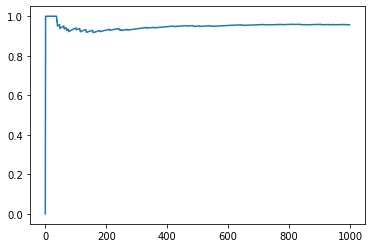

In [140]:
import matplotlib.pyplot as plt
precisions=[]
#recalls=[]
for k in range(1000):
    precisions.append(precision_score(labels[:k], preds_final[:k]))
    #recalls.append(recall_score(labels[:k], preds_final[:k]))
plt.plot(precisions)
